# Introduction

The EDA aims to explore the model's performance and accuracy in specific scenarios and to determine a preliminar grade of fidelity in its estimation.

# Import Libraries

In [1]:
# Importing libraries
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer , LabelEncoder

# Data Cleaning and Treating [I]

The dataset was loaded and its string features were converted to categorical data type and encoded to numerical values. It was not necessary to drop null values or deal with missing values. 

In addition, the dataset was grouped by the three subsets that will be used to train the corresponding sub-models.

In [2]:
# Loading [raw] dataset
ObesityDataset_Raw = pd.read_csv('ObesityDataset_Raw.csv')

In [3]:
# Getting categorical and numerical features
CategoricalFeatures = []
NumbericalFeatures = []

for label in ObesityDataset_Raw.columns:
    if ObesityDataset_Raw[label].dtype == 'object':
        CategoricalFeatures.append(label)
    else:
        NumbericalFeatures.append(label)

In [4]:
# Capitalizing values of categorical features
def CapitalizeIfNecessary(value):
    if value == 'no' or value == 'yes':
        return value.capitalize()
    else:
        return value

ObesityDataset_Raw[CategoricalFeatures] = ObesityDataset_Raw[CategoricalFeatures].map(CapitalizeIfNecessary)

In [5]:
# Transforming categorical features' data type into categorical data type
ObesityDataset_Raw[CategoricalFeatures] = ObesityDataset_Raw[CategoricalFeatures].astype('category')

In [6]:
# Encoding categorical features into numerical features

## Feature NObeyesdad
OrderedCategories_NObeyesdad = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']
Encoder_NObeyesdad = {category:value for value , category in enumerate(OrderedCategories_NObeyesdad)}
ObesityDataset_Raw['NObeyesdad_Encode'] = ObesityDataset_Raw['NObeyesdad'].map(Encoder_NObeyesdad).astype(int)

## Feature Gender
Values_Gender = ['Female', 'Male']
Encoder_Gender = {category:value for value , category in enumerate(Values_Gender)}
ObesityDataset_Raw['Gender_Encode'] = ObesityDataset_Raw['Gender'].map(Encoder_Gender).astype(int)

## Other features
Values_Binary = ['Yes','No']
__Encoder_Binary = LabelBinarizer().fit(Values_Binary)
Encoder_Binary = lambda value: __Encoder_Binary.transform([value])[0,0]

for feature in CategoricalFeatures:
    if feature != 'Gender' and feature != 'NObeyesdad':
        if len(ObesityDataset_Raw[feature].unique()) > 2:
            ObesityDataset_Raw[feature+'_Encode'] = pd.DataFrame(LabelEncoder().fit_transform(ObesityDataset_Raw[feature])).astype(int)
        else:
            ObesityDataset_Raw[feature+'_Encode'] = ObesityDataset_Raw[feature].map(Encoder_Binary).astype(int)

In [7]:
# Getting encoded categorical features
CategoricalFeatures_Encode = [feature+'_Encode' for feature in CategoricalFeatures]

In [74]:
# Grouping by Obesity level
GroupObesityLevel = ObesityDataset_Raw.groupby(by=['NObeyesdad'],observed=True)

# Subgrouping by Obesity level categories
SubgroupsObesityLevel = dict()
for subgroup in ObesityDataset_Raw['NObeyesdad'].unique():
    SubgroupsObesityLevel[subgroup] = GroupObesityLevel.get_group((subgroup,))

## Insufficient and Normal Weight
ObesityGroup_1 = ['Insufficient_Weight','Normal_Weight']
ObseityLevel_Group_1 = pd.concat([SubgroupsObesityLevel[subgroup] for subgroup in ObesityGroup_1])

## Overweight 
ObesityGroup_2 = ['Overweight_Level_I','Overweight_Level_II']
ObseityLevel_Group_2 = pd.concat([SubgroupsObesityLevel[subgroup] for subgroup in ObesityGroup_2])

## Obesity
ObesityGroup_3 = ['Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']
ObseityLevel_Group_3 = pd.concat([SubgroupsObesityLevel[subgroup] for subgroup in ObesityGroup_3])

# Gruoping by Obesity Level 
ObseityLevel_Groups = ObesityDataset_Raw.copy(deep=True)
Encoder_SubgroupsObesityLevel = {obesityLevel:group_num for group_num , group in enumerate([ObesityGroup_1,ObesityGroup_2,ObesityGroup_3]) for obesityLevel in group}
ObseityLevel_Groups['NObeyesdad_Encode'] = ObseityLevel_Groups['NObeyesdad'].map(Encoder_SubgroupsObesityLevel)

# Data Visualization and Analysis

Wether the dataset is grouped by obesity level and gender, can be seen that the number of samples in some subgroups is almost nil compared to others. For example, in obesity type II and obesity type III is observed this situation.

Therefore obesity type II, female and obesity type III, male are clases with low representation, so (preliminarily) the final model will not be able to learn enough to classify samples with this features and classes. But in the others will not apparently show this type of difficult.

In [ ]:
# Grouping by Obesity level and Gender
ObesityDataset_Raw.groupby(by=['NObeyesdad','Gender'],observed=True)['Age'].describe()[['count']]

count
NObeyesdad          Gender       
Insufficient_Weight Female  173.0
                    Male     99.0
Normal_Weight       Female  141.0
                    Male    146.0
Obesity_Type_I      Female  156.0
                    Male    195.0
Obesity_Type_II     Female    2.0
                    Male    295.0
Obesity_Type_III    Female  323.0
                    Male      1.0
Overweight_Level_I  Female  145.0
                    Male    145.0
Overweight_Level_II Female  103.0
                    Male    187.0

In the full dataset, the weight, the height and family history with overweight are feature that are more correlated with other features. Stating that these features are almost determined by the former. The weight having the greatest impact on predicting the target's value.

Other categorical features do not show a hight correlation value with other features, implies that either are independent variables or their interaction is no lineal. 

Another observation to be made is that the features related to habits may not be relevant to classify a data point into Insufficient-Normal Weight, Overweight or Obesity [class for the first sub-model] and be more able to distinguish between obesity levels. 

<Axes: >

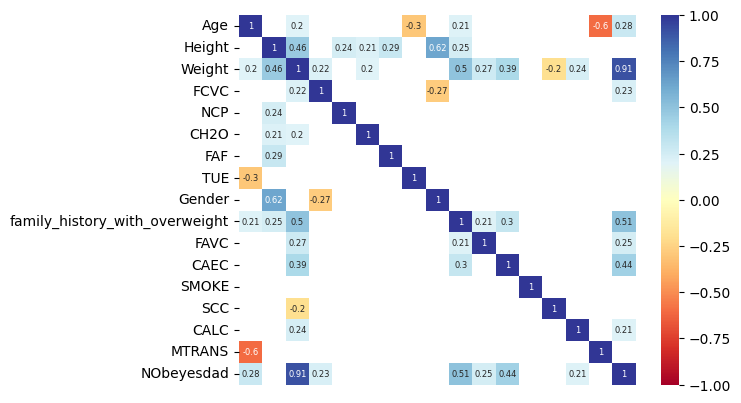

In [39]:
# Plotting correlation between features in full dataset
CorrelationMatrix_Full = ObesityDataset_Raw[NumbericalFeatures+CategoricalFeatures_Encode].corr()
MaskValues_Full = CorrelationMatrix_Full.apply(lambda value: abs(value)<=0.2)
TickLabels_Y = NumbericalFeatures+CategoricalFeatures
sns.heatmap(CorrelationMatrix_Full,mask=MaskValues_Full,cmap='RdYlBu',yticklabels=TickLabels_Y,xticklabels=False,vmax=1,vmin=-1,annot=True,annot_kws={'size':6})

<Axes: >

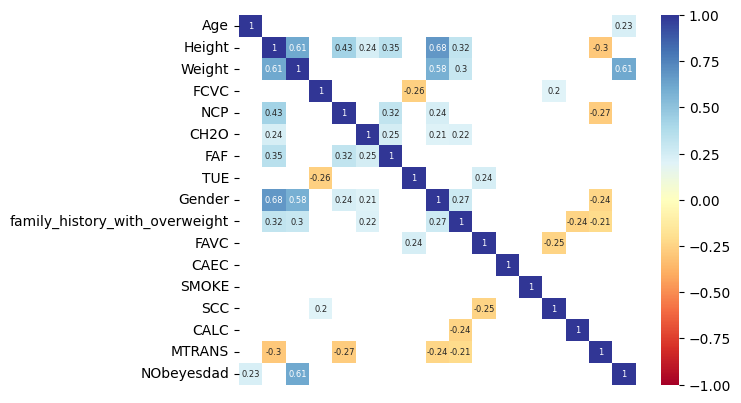

In [40]:
# Plotting correlation between features in group 1 :: Insufficient and Normal weight
CorrelationMatrix_Group1 = ObseityLevel_Group_1[NumbericalFeatures+CategoricalFeatures_Encode].corr()
MaskValues_Group1 = CorrelationMatrix_Group1.apply(lambda value: abs(value)<=0.2)
TickLabels_Y = NumbericalFeatures+CategoricalFeatures
sns.heatmap(CorrelationMatrix_Group1,mask=MaskValues_Group1,cmap='RdYlBu',yticklabels=TickLabels_Y,xticklabels=False,vmax=1,vmin=-1,annot=True,annot_kws={'size':6})

<Axes: >

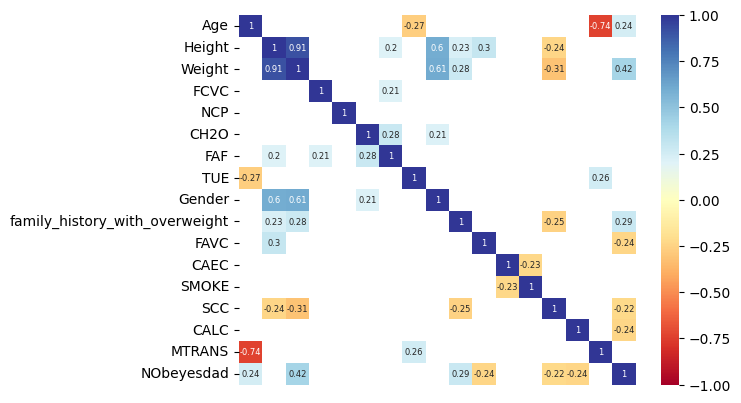

In [41]:
# Plotting correlation between features in group 2 :: Overweight
CorrelationMatrix_Group2 = ObseityLevel_Group_2[NumbericalFeatures+CategoricalFeatures_Encode].corr()
MaskValues_Group2 = CorrelationMatrix_Group2.apply(lambda value: abs(value)<=0.2)
TickLabels_Y = NumbericalFeatures+CategoricalFeatures
sns.heatmap(CorrelationMatrix_Group2,mask=MaskValues_Group2,cmap='RdYlBu',yticklabels=TickLabels_Y,xticklabels=False,vmax=1,vmin=-1,annot=True,annot_kws={'size':6})

<Axes: >

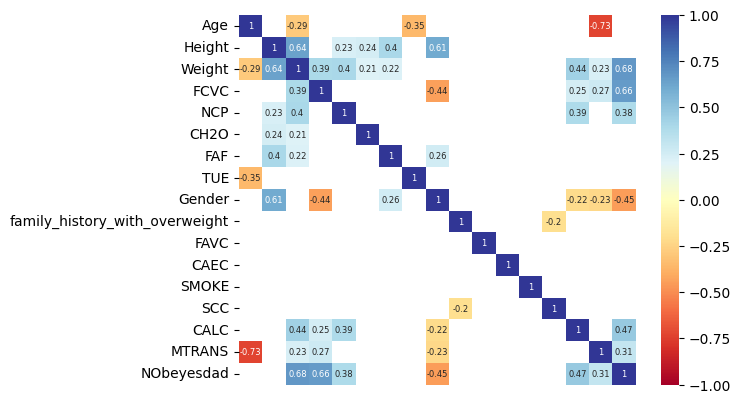

In [42]:
# Plotting correlation between features in group 3 :: Obesity
CorrelationMatrix_Group3 = ObseityLevel_Group_3[NumbericalFeatures+CategoricalFeatures_Encode].corr()
MaskValues_Group3 = CorrelationMatrix_Group3.apply(lambda value: abs(value)<=0.2)
TickLabels_Y = NumbericalFeatures+CategoricalFeatures
sns.heatmap(CorrelationMatrix_Group3,mask=MaskValues_Group3,cmap='RdYlBu',yticklabels=TickLabels_Y,xticklabels=False,vmax=1,vmin=-1,annot=True,annot_kws={'size':6})

Because of the physical condition (insufficient weight, normal weight, overweight and obesity) is strongly related to the height, weight, gender and age of someone, hence these features become relevant for the model.

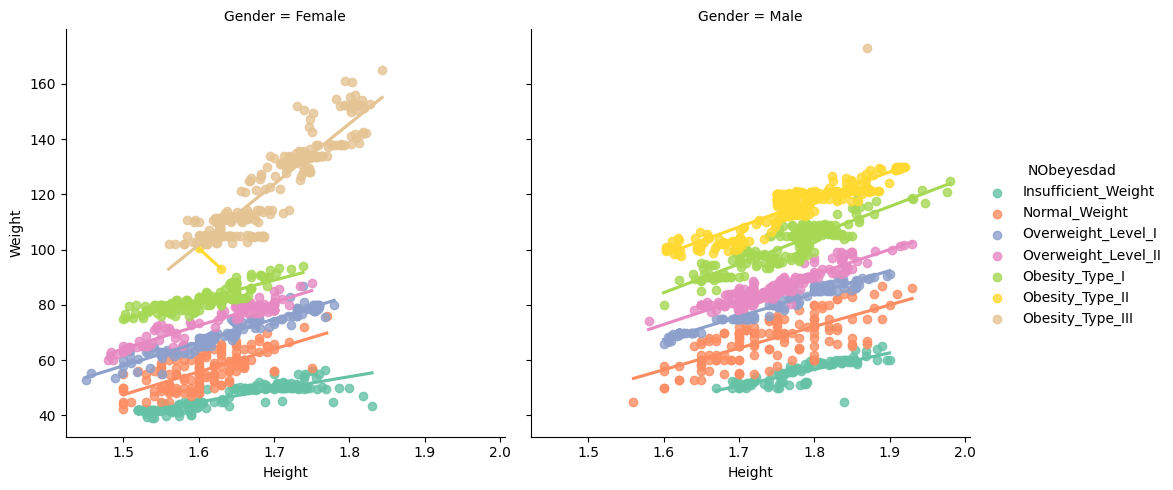

In [236]:
ObesityLevelOrder = ['Insufficient_Weight','Normal_Weight','Overweight_Level_I','Overweight_Level_II','Obesity_Type_I','Obesity_Type_II','Obesity_Type_III']

sns.lmplot(data=ObesityDataset_Raw,x='Height',y='Weight',hue='NObeyesdad',col='Gender',hue_order=ObesityLevelOrder,palette='Set2',ci=None)

The before plot shows this strong relation and also show that there are not enough data points (samples) in some categories of obesity level - gender. Therefore in some scenarios the model will have a poor estimation quality.